In [1]:
import os
import json

def is_valid_segment(segment):
    return len(segment['speakers']) == 1 \
            and len(segment['ivectors']) == 1 \
            and len(segment['xvectors']) == 1 \
            # and segment['speakers'][0]['speaker_id'] in ['A', 'B']

directory = 'exp/json'
filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]

recordings_segments = {}
recordings_length = len(filenames)
recordings_count = 0
for filename in filenames:
    recording_id = filename.split('.')[0]
    filepath = os.path.join(directory, filename)
    file = open(filepath, 'r')
    recordings_segments[recording_id] = [json.loads(line) for line in file.readlines()]
    file.close()
    recordings_segments[recording_id] = list(filter(is_valid_segment, recordings_segments[recording_id]))
    recordings_count += 1
    print('Loading data: ' + str(recordings_count) + '/' + str(recordings_length), end = '\r')

In [2]:
from torch.utils.data import Dataset
from functools import reduce
import numpy as np
import itertools

models_container_length = 4

def speakers_get_indexes(accumulator, speaker_tuple):
    speaker_id, index = speaker_tuple
    if speaker_id in accumulator:
        accumulator[speaker_id].append(index)
    else:
        accumulator[speaker_id] = [index]
    return accumulator

class Recordings_dataset(Dataset):
    def __init__(self, recordings_segments, recordings_ids, mode = 'ivectors'):
        self.recordings_segments = recordings_segments
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
        self.mode = mode
        self.models_generation_length = 5
        self.models_container_length = models_container_length
        self.recordings_data = {}
        recordings_map = [] # idx --> recording_id
        recordings_length = 0
        for recording_id in self.recordings_ids:
            self.recordings_data[recording_id] = {}
            speakers_indexes = [(segment['speakers'][0]['speaker_id'], index) for index, segment in enumerate(self.recordings_segments[recording_id])]
            speakers_indexes = reduce(speakers_get_indexes, speakers_indexes, {})
            speakers_models = {}
            for speaker_id in speakers_indexes:
                speaker_vectors = [np.asarray(segment[mode][0]['value']) for segment in self.recordings_segments[recording_id][:self.models_generation_length]]
                speakers_models[speaker_id] = [np.sum(speaker_vectors, 0) / len(speaker_vectors)]
            self.recordings_data[recording_id]['speakers_models'] = speakers_models
            permutations = list(itertools.permutations(list(speakers_models.keys()) \
            + ['0' for i in range(self.models_container_length)], self.models_container_length))
            permutations = list(set(permutations))
            print(permutations[0])
            permutations_map = [] # idx --> permutation
            permutations_length = 0
            for index, permutation in enumerate(permutations):
                speakers_models_length = int(np.prod([len(speakers_models[speaker_id]) for speaker_id in permutation if speaker_id != '0']))
                permutations_map.append((permutations_length, permutations_length + speakers_models_length - 1, index))
                permutations_length += speakers_models_length
            self.recordings_data[recording_id]['permutations'] = permutations
            self.recordings_data[recording_id]['permutations_map'] = permutations_map
            self.recordings_data[recording_id]['permutations_length'] = permutations_length
            recording_length = len(self.recordings_segments[recording_id]) * permutations_length
            recordings_map.append((recordings_length, recordings_length + recording_length - 1, recording_id))
            recordings_length += recording_length
        self.recordings_map = recordings_map
        self.recordings_length = recordings_length
    def __len__(self):
        return self.recordings_length
    def __getitem__(self, index):
        recording_tuple = list(filter(lambda recording_tuple: recording_tuple[0] <= index and index <= recording_tuple[1], self.recordings_map))[0]
        recording_id = recording_tuple[2]
        recording_index = index - recording_tuple[0] # <-- inside record index
        recording_data = self.recordings_data[recording_id]
        
        segment_index, remainder = divmod(recording_index, recording_data['permutations_length'])
        segment = recordings_segments[recording_id][segment_index]
        vector = segment[self.mode][0]['value']

        permutation_tuple = list(filter(lambda permutation_tuple: permutation_tuple[0] <= remainder and remainder <= permutation_tuple[1], recording_data['permutations_map']))[0]
        permutation_id = permutation_tuple[2]
        permutation = recording_data['permutations'][permutation_id]
        
        models_container = [recording_data['speakers_models'][speaker_id][0] if speaker_id != '0' else np.zeros(len(vector)) for speaker_id in permutation]
        
        # x <-- segment vector
        x = np.concatenate([vector] + models_container)
        # y <-- speakers models
        y = np.asarray([speaker_id == segment['speakers'][0]['speaker_id'] for speaker_id in permutation], dtype = 'float')
        # z <-- segment t
        z = segment_index
        
        return x, y, z


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear((models_container_length + 1) * 128, 16)
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, models_container_length)
    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x


In [10]:
from torch.utils.data import DataLoader, random_split

recordings_dataset = Recordings_dataset(recordings_segments, ['iako'])
print(len(recordings_dataset))

train_length = int(len(recordings_dataset) * 0.7)
test_length = len(recordings_dataset) - train_length
cross_length = int(train_length * 0.3)
train_length = train_length - cross_length

train_dataset, cross_dataset, test_dataset = random_split(recordings_dataset, [train_length, cross_length, test_length])
train_dataloader = DataLoader(train_dataset, batch_size = 50, shuffle=True, num_workers = 4)
cross_dataloader = DataLoader(cross_dataset, batch_size = len(cross_dataset), num_workers = 4)

('B', 'B1', 'A', 'A1')
57475


In [11]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU.')
else:
    device = torch.device('cpu')
    print('Running on the CPU.')


Running on the GPU.


<IPython.core.display.Javascript object>


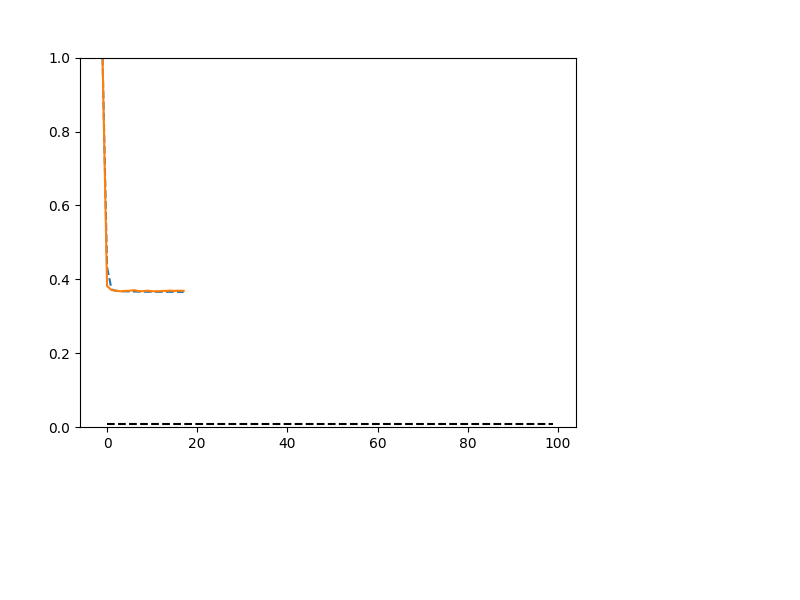

KeyboardInterrupt: 

In [12]:
%matplotlib notebook
import torch.optim as optim
import matplotlib.pyplot as plt

net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.BCELoss()

epochs = 100
cross_loss_thr = 0.01

plt_thr = (np.linspace(0, epochs - 1, epochs), np.ones(epochs) * cross_loss_thr)
plt_loss = ([-1], [1])
plt_valid = ([-1], [1])

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim(0, 1.0)
line0, = ax.plot(plt_thr[0], plt_thr[1], 'k--')  # Threshold line
line1, = ax.plot(plt_loss[0], plt_loss[1], '--') # Training loss
line2, = ax.plot(plt_valid[0], plt_valid[1])     # Validation loss
fig.canvas.draw()
fig.canvas.flush_events()

for epoch in range(epochs):
    losses = []
    for input, target, t in train_dataloader:
        input = input.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).float()

        net.zero_grad()

        output = net(input)

        loss = criterion(output, target)
        losses.append(loss.data)

        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for input, target, t in cross_dataloader:
            input = input.to(device, non_blocking=True).float()
            target = target.to(device, non_blocking=True).float()
            output = net(input)
            cross_loss = criterion(output, target)
            
    plt_loss[0].append(epoch)
    plt_loss[1].append(np.sum(losses) / len(losses))
    plt_valid[0].append(epoch)
    plt_valid[1].append(cross_loss.data)
    line1.set_xdata(plt_loss[0])
    line1.set_ydata(plt_loss[1])
    line2.set_xdata(plt_valid[0])
    line2.set_ydata(plt_valid[1])
    fig.canvas.draw()
    fig.canvas.flush_events()    
        
    # print('epoch:', epoch, 'loss:', loss, 'cross_loss:', cross_loss, end = '\r')
    
    if cross_loss < cross_loss_thr:
        print('Done training.')
        break